In [2]:
!pip install albumentations
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [3]:
!pip install segmentation-models-pytorch
!pip install torchsummary


In [4]:
!pip install huggingface-hub==0.16.4


  Using cached huggingface_hub-0.16.4-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.16.4 which is incompatible.
segmentation-models-pytorch 0.3.4 requires huggingface-hub>=0.24.6, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.16.4 which is incompatible.


In [5]:
import segmentation_models_pytorch as smp
from torchsummary import summary


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


c:\Users\Yang_PC\anaconda3\envs\py310cuda118\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


device(type='cuda')

In [7]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cu118


In [8]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 3060


In [9]:
import os
import pandas as pd

# Define paths to the train, valid, and test image and mask folders
import os
import glob

main_folder = r'D:\ML_Seagrass\SourceData\Alaska\Alaska'

# Define the folders for images, masks, and additional channels
train_image_folder = os.path.join(main_folder, 'train', 'image')
train_mask_folder = os.path.join(main_folder, 'train', 'index')
val_image_folder = os.path.join(main_folder, 'valid', 'image')
val_mask_folder = os.path.join(main_folder, 'valid', 'index')
test_image_folder = os.path.join(main_folder, 'test', 'image')
test_mask_folder = os.path.join(main_folder, 'test', 'index')
train_ch4_folder = os.path.join(main_folder, 'train', 'glcm')
train_ch5_folder = os.path.join(main_folder, 'train', 'glcm')
valid_ch4_folder = os.path.join(main_folder, 'valid', 'glcm')
valid_ch5_folder = os.path.join(main_folder, 'valid', 'glcm')

# Collect file paths for each set using glob
train_image_files = glob.glob(os.path.join(train_image_folder, '*.png'))  # Adjust extension as needed
train_mask_files = glob.glob(os.path.join(train_mask_folder, '*.png'))
val_image_files = glob.glob(os.path.join(val_image_folder, '*.png'))
val_mask_files = glob.glob(os.path.join(val_mask_folder, '*.png'))
test_image_files = glob.glob(os.path.join(test_image_folder, '*.png'))
test_mask_files = glob.glob(os.path.join(test_mask_folder, '*.png'))

train_ch4_files = glob.glob(os.path.join(train_ch4_folder, '*.png'))
train_ch5_files = glob.glob(os.path.join(train_ch5_folder, '*.png'))
valid_ch4_files = glob.glob(os.path.join(valid_ch4_folder, '*.png'))
valid_ch5_files = glob.glob(os.path.join(valid_ch5_folder, '*.png'))

# Verify the number of files collected
print("Number of training images:", len(train_image_files))
print("Number of training masks:", len(train_mask_files))
print("Number of validation images:", len(val_image_files))
print("Number of validation masks:", len(val_mask_files))
print("Number of training ch4 images:", len(train_ch4_files))
print("Number of training ch5 images:", len(train_ch5_files))
print("Number of validation ch4 images:", len(valid_ch4_files))
print("Number of validation ch5 images:", len(valid_ch5_files))

    
# Function to create dataframes from the given folder structure
def create_dataframes_from_main_folder(main_folder):
    

    # Helper function to create a dataframe from image and mask folders
    def create_dataframe_from_folders(image_folder, mask_folder):
        image_names = [img.split('.')[0] for img in os.listdir(image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
        mask_names = [mask.split('.')[0] for mask in os.listdir(mask_folder) if mask.endswith(('.jpg', '.png', '.jpeg'))]

        # Ensure that the image and mask file names match
        assert set(image_names) == set(mask_names), "Image and mask file names do not match!"

        return pd.DataFrame({'id': image_names})

    # Create dataframes for train, valid, and test sets
    df_train = create_dataframe_from_folders(train_image_folder, train_mask_folder)
    df_val = create_dataframe_from_folders(val_image_folder, val_mask_folder)
    df_test = create_dataframe_from_folders(test_image_folder, test_mask_folder)

    # Return dataframes
    return df_train, df_val, df_test

  # Replace with the path to your main folder
df_train, df_val, df_test = create_dataframes_from_main_folder(main_folder)

# Assign X_train, X_val, and X_test
X_train = df_train['id'].values
X_val = df_val['id'].values
X_test = df_test['id'].values


Number of training images: 840
Number of training masks: 840
Number of validation images: 240
Number of validation masks: 240
Number of training ch4 images: 840
Number of training ch5 images: 840
Number of validation ch4 images: 240
Number of validation ch5 images: 240


Image Path: D:\ML_Seagrass\SourceData\Alaska\Alaska\valid\image\FI_AK_19_row10_col16.png
Mask Path: D:\ML_Seagrass\SourceData\Alaska\Alaska\valid\index\FI_AK_19_row10_col16.png


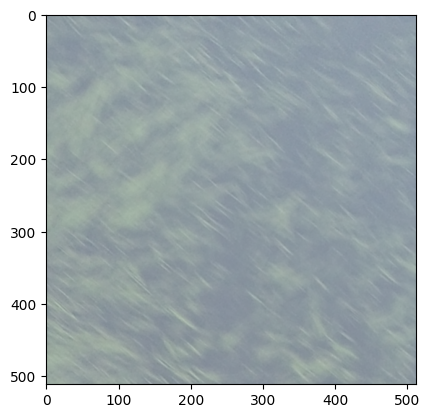

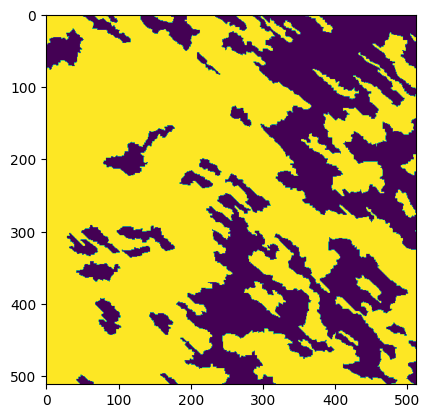

(512, 512, 3)
(512, 512)


In [10]:
for idx in X_val:
    img_path = os.path.join(val_image_folder, idx + '.png')
    mask_path = os.path.join(val_mask_folder, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [11]:
from pathlib import Path

class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, ch4_path, ch5_path, X, mean, std, transform=None, patch=False):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch
        self.ch4_path = ch4_path
        self.ch5_path = ch5_path

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        img_ch4_path = os.path.join(self.ch4_path ,f'{self.X[idx]}.png')
        if self.ch5_path is not None and len(self.ch5_path)>1:
            img_ch5_path = os.path.join(self.ch5_path, f'{self.X[idx]}.png')
        else:
            img_ch5_path = None
                    
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_ch4 = cv2.imread(str(img_ch4_path), cv2.IMREAD_GRAYSCALE)
        
        img_ch5 = None
        if img_ch5_path is not None:
            img_ch5 = cv2.imread(str(img_ch5_path), cv2.IMREAD_GRAYSCALE)
            
        img_ch4 = np.expand_dims(img_ch4, axis=2)
        img_with_4ch = np.concatenate((img, img_ch4), axis=2)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        mask = np.array(mask)

        # Map mask values: 255 -> 1
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        # if self.transform is not None:
        #     aug = self.transform(image=img, mask=mask)
        #     img = aug['image']
        #     mask = aug['mask']
            
        if self.transform is not None:
            print(f'img_with_4ch: {img_with_4ch.shape}  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
            aug = self.transform(image=img_with_4ch, mask=mask)
            img_with_4ch = aug['image']
            mask = aug['mask']
            
            print(f'img_with_4ch: {img_with_4ch.shape}  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb')
            
        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        # img = t(img)
        img = t(img_with_4ch)
        
        # Convert mask to a tensor
        mask = torch.from_numpy(mask).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        print(f'img: {img.shape}  cccccccccccccccccccccccccccccccccc')
        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass

In [12]:
from torch.utils.data import Dataset
import torch
import numpy as np
from skimage import io

class Drone_data_5xxx(Dataset):
    def __init__(self, image_paths, mask_paths, ch4_paths, ch5_paths, transform=None, eval_ori_resolution=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.ch4_paths = ch4_paths
        self.ch5_paths = ch5_paths
        self.transform = transform
        self.eval_ori_resolution = eval_ori_resolution

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the main RGB image
        image_path = self.image_paths[idx]
        image = io.imread(image_path)
        print(f"Loaded image shape: {image.shape}")

        # Load the corresponding mask (ground truth)
        mask_path = self.mask_paths[idx]
        mask = io.imread(mask_path)

        # Load additional channels
        ch4_path = self.ch4_paths[idx]
        ch4 = io.imread(ch4_path)
        
        ch5_path = self.ch5_paths[idx]
        ch5 = io.imread(ch5_path)

        # Ensure mask is grayscale
        if len(mask.shape) > 2:
            mask = mask[:, :, 0]

        # Ensure the main image has 3 channels
        if len(image.shape) < 3:
            image = image[:, :, np.newaxis]
        if image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)

        # Ensure additional channels are single-channel
        if ch4.shape[2] > 1:
            ch4 = ch4[:, :, 0]
        if ch5.shape[2] > 1:
            ch5 = ch5[:, :, 0]

        # Convert additional channels to the correct shape
        ch4 = ch4[:, :, np.newaxis]
        ch5 = ch5[:, :, np.newaxis]

        # Concatenate the original image with the additional channels
        image_5channel = np.concatenate((image, ch4, ch5), axis=2)

        # Convert to PyTorch tensors and rearrange dimensions
        image_5channel = torch.tensor(image_5channel.copy(), dtype=torch.float32)
        image_5channel = torch.permute(image_5channel, (2, 0, 1))

        image = torch.tensor(image.copy(), dtype=torch.float32)
        image = torch.permute(image, (2, 0, 1))

        mask = torch.unsqueeze(torch.tensor(mask, dtype=torch.float32), 0)

        # Prepare the sample as a dictionary
        sample = {
            "imidx": torch.tensor(idx),
            "image": image,
            "label": mask,
            "shape": torch.tensor(image.shape[-2:]),
            "image_5channel": image_5channel
        }

        # Apply transformations if provided
        if self.transform:
            sample = self.transform(sample)

        # Add original resolution labels and paths for evaluation if required
        if self.eval_ori_resolution:
            sample["ori_label"] = mask.type(torch.uint8)  # For evaluation only, without transformations
            sample['ori_im_path'] = image_path
            sample['ori_gt_path'] = mask_path

        return sample


In [18]:
import albumentations as A
import cv2
from torch.utils.data import DataLoader

# Mean and standard deviation for 5 channels (adjust last two values for ch4 and ch5)
mean = [0.485, 0.456, 0.406, 0.5]
std = [0.229, 0.224, 0.225, 0.22]

# Define Albumentations transforms
t_train = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
    A.GaussNoise()
])

t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
])

# Create datasets using the lists of actual file paths
# train_set = Drone_data(
#     image_paths=train_image_files,  # List of image file paths
#     mask_paths=train_mask_files,    # List of mask file paths
#     ch4_paths=train_ch4_files,      # List of ch4 image file paths
#     ch5_paths=train_ch5_files,      # List of ch5 image file paths
#     transform=t_train,
#     eval_ori_resolution=False  # Set to True if you want to include original paths and labels for evaluation
# )

# val_set = Drone_data(
#     image_paths=val_image_files,  # List of validation image file paths
#     mask_paths=val_mask_files,    # List of validation mask file paths
#     ch4_paths=valid_ch4_files,    # List of validation ch4 image file paths
#     ch5_paths=valid_ch5_files,    # List of validation ch5 image file paths
#     transform=t_val,
#     eval_ori_resolution=False  # Set to True if you want to include original paths and labels for evaluation
# )

train_set = Drone_data(train_image_folder, train_mask_folder,train_ch4_folder, None, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(val_image_folder, val_mask_folder, valid_ch4_folder, None, X_val, mean, std, t_val, patch=False)

# Create dataloaders
batch_size = 4
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)



img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
img_with_4ch: (512, 512, 4)  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
img_with_4ch: (704, 1056, 4)  bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
img: torch.Size([4, 704, 1056])  cccccccccccccccccccccccccccccccccc
Image 1


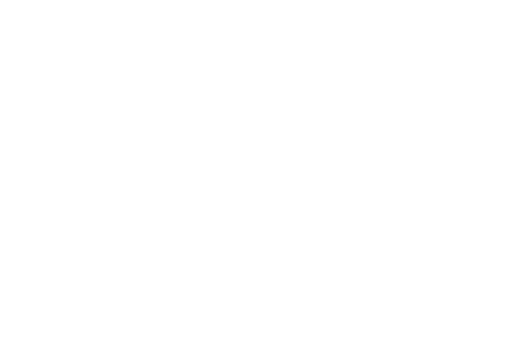

Image 2


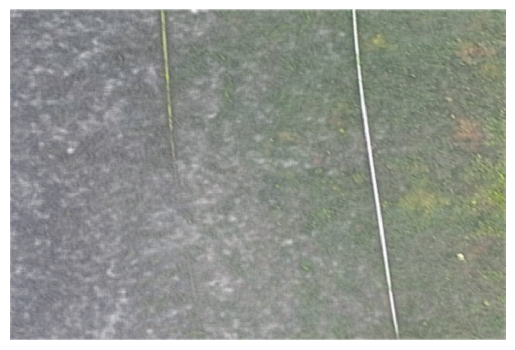

Image 3


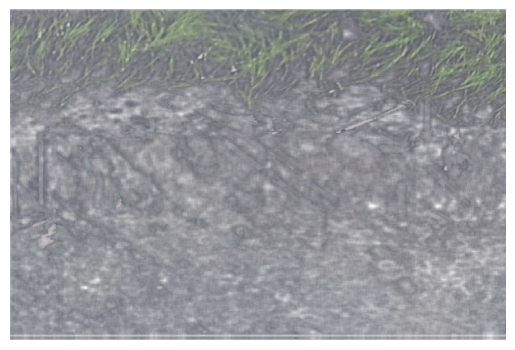

Image 4


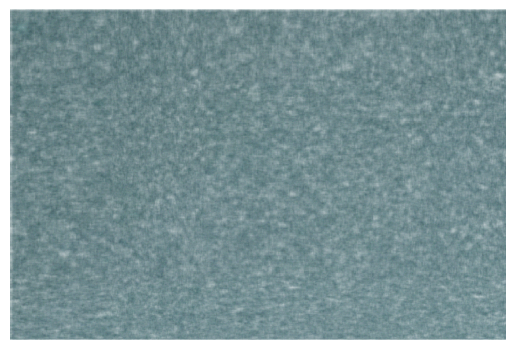

In [20]:
def visualize_4ch_image(img_tensor, mean, std):
    # Un-normalize the image
    img = img_tensor.clone()  # Clone to avoid modifying the original tensor

    # Separate the RGB and GLCM channels for better visualization
    rgb_mean = mean[:3]
    rgb_std = std[:3]
    
    # Un-normalize only the first 3 channels (RGB)
    for t, m, s in zip(img[:3], rgb_mean, rgb_std):
        t.mul_(s).add_(m)

    # Convert RGB channels to numpy format
    img_rgb = img[:3].permute(1, 2, 0).numpy()  # Only the RGB channels, rearrange to HWC

    # Clip RGB values between 0 and 1 for display
    img_rgb = np.clip(img_rgb, 0, 1)

    # Display RGB image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("RGB Channels")

    # Display GLCM channel as a separate grayscale image
    glcm_channel = img[3].numpy()  # 4th channel (GLCM)
    
    plt.subplot(1, 2, 2)
    plt.imshow(glcm_channel, cmap="gray")
    plt.axis('off')
    plt.title("GLCM Channel")
    
    plt.show()

# Visualize a batch of images from the DataLoader
def visualize_batch_4ch(loader, mean, std):
    for images, masks in loader:
        for i in range(len(images)):
            print(f"Image {i+1}")
            visualize_4ch_image(images[i], mean, std)  # Call the visualization function for each image
        break  # Show only the first batch for simplicity

# Call the function with your train or validation DataLoader
visualize_batch_4ch(train_loader, mean, std)  # For training images with 4 channels


In [153]:
# import albumentations as A
# import cv2
# from torch.utils.data import DataLoader

# # Mean and standard deviation for 5 channels (adjust last two values for ch4 and ch5)
# mean = [0.485, 0.456, 0.406, 0.5, 0.5]  
# std = [0.229, 0.224, 0.225, 0.2, 0.2]

# # Define Albumentations transforms
# t_train = A.Compose([
#     A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
#     A.HorizontalFlip(),
#     A.VerticalFlip(),
#     A.GridDistortion(p=0.2),
#     A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
#     A.GaussNoise()
# ])

# t_val = A.Compose([
#     A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
#     A.HorizontalFlip(),
#     A.GridDistortion(p=0.2)
# ])

# # Create datasets using the lists of actual file paths
# train_set = Drone_data(
#     image_paths=train_image_files,  # List of image file paths
#     mask_paths=train_mask_files,    # List of mask file paths
#     ch4_paths=train_ch4_files,      # List of ch4 image file paths
#     ch5_paths=train_ch5_files,      # List of ch5 image file paths
#     transform=t_train,
#     eval_ori_resolution=False  # Set to True if you want to include original paths and labels for evaluation
# )

# val_set = Drone_data(
#     image_paths=val_image_files,  # List of validation image file paths
#     mask_paths=val_mask_files,    # List of validation mask file paths
#     ch4_paths=valid_ch4_files,    # List of validation ch4 image file paths
#     ch5_paths=valid_ch5_files,    # List of validation ch5 image file paths
#     transform=t_val,
#     eval_ori_resolution=False  # Set to True if you want to include original paths and labels for evaluation
# )

# # Create dataloaders
# batch_size = 4
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)



In [154]:
# model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', in_channels=3, classes=2, activation=None)
model = smp.Unet('resnet50', encoder_weights='imagenet', in_channels=3, classes=2, activation=None)


In [155]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

In [156]:
class ChannelReducer(nn.Module):
    def __init__(self):
        super(ChannelReducer, self).__init__()
        self.conv = nn.Conv2d(4, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        return self.conv(x)

class UnetWith5Channels(nn.Module):
    def __init__(self, unet_model):
        super(UnetWith5Channels, self).__init__()
        self.channel_reducer = ChannelReducer()
        self.unet = unet_model
    

    def forward(self, x):
        x = self.channel_reducer(x)
        return self.unet(x)


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model = UnetWith5Channels(model)####
    
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # Unpack the 5-channel image and mask tiles from the dataloader
            # image_tiles = data["image_5channel"]
            # mask_tiles = data["label"]
            image_tiles, mask_tiles = data
            
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            # Move the images and masks to the specified device (e.g., GPU)
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            # Forward pass with 5-channel image
            output = model(image)

            # Calculate loss
            loss = criterion(output, mask)

            # Calculate evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # Unpack the 5-channel image and mask tiles from the dataloader
                    # image_tiles = data["image_5channel"]
                    # mask_tiles = data["label"]
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            if min_loss > (test_loss / len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score / len(val_loader)))

            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time() - since) / 60))

    history = {'train_loss': train_losses, 'val_loss': test_losses,
               'train_miou': train_iou, 'val_miou': val_iou,
               'train_acc': train_acc, 'val_acc': val_acc,
               'lrs': lrs}

    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    return history


In [157]:
torch.cuda.empty_cache()

In [ ]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

In [ ]:
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

torch.save(model, 'Unet-Unet50-batchsize4-AK_lr-4_4CHANNEL.pt')

In [ ]:
model_path = r'C:\Users\Yang_PC\Documents\Github\ArcgisPro-Customized-Toolbox\Notebook\Unet-Unet50-batchsize4-AK_lr-4_4CHANNEL.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path)
model.to(device)




In [161]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [170]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_file_name = f'{self.X[idx]}.png'
        img_path = self.img_path / img_file_name
        mask_path = self.mask_path / img_file_name
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        # Return the image, mask, and file name
        return img, mask, img_file_name

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(test_image_folder, test_mask_folder, X_test, transform=t_test)

In [173]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Updated function to perform inference and save the predicted mask with resizing
def predict_image_mask_miou(model, image, mask, save_file, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode
    
    # Store original image dimensions before transforming
    original_height, original_width = 512, 512  # PIL Image size: (width, height)
    
    # Apply transformation to the image (e.g., normalization)
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image_tensor = t(image)  # Keep 'image' unchanged for later use
    
    # Move image and mask to the appropriate device
    image_tensor = image_tensor.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension for the model
        mask = mask.unsqueeze(0)    # Add batch dimension

        output = model(image_tensor)  # Run model inference
        score = mIoU(output, mask)  # Compute mIoU score
        
        # Get the predicted mask by taking the argmax of the model's output
        pred_mask = torch.argmax(output, dim=1)
        pred_mask = pred_mask.cpu().squeeze(0)  # Move to CPU and remove batch dimension

    # Resize the predicted mask to match the original image size
    pred_mask_resized = cv2.resize(pred_mask.numpy(), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    
    # Save the resized predicted mask as a grayscale image
    plt.imsave(save_file, pred_mask_resized, cmap='gray')  # Save mask as a grayscale image
    
    return pred_mask_resized, score



def save_predicted_mask_overlay(pred_mask, img_file_name, image_folder, save_file, alpha=0.5):
    """
    Overlays the predicted mask on the original image read from a specified folder, and saves the result.
    
    Parameters:
    - pred_mask: The predicted mask (PyTorch tensor or NumPy array with values 0 and 1).
    - img_file_name: The name of the image file (e.g., 'image_001.png').
    - image_folder: The path to the folder where the original image is located.
    - save_file: The path to save the overlaid image.
    - alpha: The transparency factor for the overlay (default is 0.3 for higher transparency).
    """
    # Build the full image path
    img_path = os.path.join(image_folder, img_file_name)

    # Read the original image from the specified folder
    original_image = Image.open(img_path).convert('RGB')  # Use PIL to read the image
    original_image = np.array(original_image)  # Convert to NumPy array

    # Convert the predicted mask to a NumPy array if it's a PyTorch tensor
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    # Ensure the predicted mask has 2D shape (height, width)
    if pred_mask.ndim != 2:
        raise ValueError(f"Expected 2D mask, but got shape {pred_mask.shape}")

    # Resize the predicted mask to match the original image size (assuming original image size is 512x512)
    original_height, original_width = original_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Ensure the image is in the correct format (height, width, 3)
    if original_image.ndim != 3 or original_image.shape[2] != 3:
        raise ValueError(f"Expected 3D RGB image, but got shape {original_image.shape}")

    # Create a copy of the original image to modify
    overlay = original_image.copy()

    # Broadcast the mask across the 3 RGB channels (set the mask area to light blue)
    light_blue_color = [78,156,217]  # Light blue RGB
    light_blue_mask = np.zeros_like(overlay)
    light_blue_mask[pred_mask_resized == 1] = light_blue_color  # Light blue for class 1 (object)

    # Blend the original image and the light blue mask, keeping the original image intensity intact
    blended_image = cv2.addWeighted(light_blue_mask, alpha, original_image, 1, 0)

    # Save the blended image
    plt.imsave(save_file, blended_image)
    print(f"Saved overlay image: {save_file}")


In [ ]:
import os
from tqdm import tqdm

# Define the save path for the predicted masks and the folder for original images
original_image_folder = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\image'  # Folder with original images
save_path = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay'
Pred_mask_path = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\predicted'

# Ensure the directories exist
os.makedirs(save_path, exist_ok=True)
os.makedirs(Pred_mask_path, exist_ok=True)

# Loop through all images in the test set
for idx in tqdm(range(len(test_set))):
    image, mask, img_file_name = test_set[idx]  # Get mask and filename from test_set
    
    # Define the save path for the current predicted mask
    save_overlay_file = os.path.join(save_path, f'{img_file_name}')  # Save with filename
    save_predicted_file = os.path.join(Pred_mask_path, f'{img_file_name}')
     
    # Run inference to get the predicted mask
    pred_mask, score = predict_image_mask_miou(model, image, mask, save_predicted_file)
    
    # Save the overlay of the predicted mask on the original image read from `original_image_folder`
    save_predicted_mask_overlay(pred_mask, img_file_name, original_image_folder, save_overlay_file)
    
    # Optionally, log the progress or save additional data
    print(f"Saved predicted mask for {img_file_name} with mIoU score: {score:.3f}")
